### Creating Pyspark Connection to BigQuery

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, current_date, datediff, expr
from pyspark.sql.functions import avg, count
from pyspark.sql import functions as F

In [2]:
# Step 1: Initialize Spark Session with BigQuery Connector
spark = SparkSession.builder \
    .appName("BigQueryExample") \
    .config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.29.0") \
    .config("credentialsFile", "vidhi-aoc-fall2024-a3a94564f449.json") \
    .getOrCreate()

:: loading settings :: url = jar:file:/opt/homebrew/Cellar/apache-spark/3.5.2/libexec/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/vidhiagrawal/.ivy2/cache
The jars for the packages stored in: /Users/vidhiagrawal/.ivy2/jars
com.google.cloud.spark#spark-bigquery-with-dependencies_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ceaee21f-6427-4596-8f55-3e89d787ec9a;1.0
	confs: [default]
	found com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.29.0 in central
:: resolution report :: resolve 137ms :: artifacts dl 3ms
	:: modules in use:
	com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.29.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------

### Analysis on before and after 2020 datasets

The split was performed in BigQuery itself and the SQL query for that is below

<img src="query_split.png">

### Read the before and after datasets using a pyspark session connected to BigQuery

#### Project ID: vidhi-aoc-fall2024

#### Dataset on BigQuery: `nyc_311_2024`

#### Tables:
1. **before_2020**  
   Contains records prior to the year 2020.
   
2. **after_2020**  
   Contains records from the year 2020 onwards.

In [3]:
service_requests_before2020 = spark.read \
    .format("bigquery") \
    .option("table", "vidhi-aoc-fall2024.nyc_311_2024.before_2020") \
    .option("parentProject", "vidhi-aoc-fall2024")\
    .load()

# Convert timestamps to UTC
service_requests_before2020 = service_requests_before2020.withColumn(
    "Created Date", F.to_utc_timestamp("Created Date", "America/New_York")
)

In [4]:
service_requests_after2020 = spark.read \
    .format("bigquery") \
    .option("table", "vidhi-aoc-fall2024.nyc_311_2024.after_2020") \
    .option("parentProject", "vidhi-aoc-fall2024")\
    .load()

# Convert timestamps to UTC
service_requests_after2020 = service_requests_after2020.withColumn(
    "Created Date", F.to_utc_timestamp("Created Date", "America/New_York")
)

In [5]:
# Get the minimum created date
min_created_date = service_requests_after2020.agg(F.min("Created Date")).collect()[0][0]

# Print the minimum created date
print(min_created_date)

2020-01-01 00:00:00


#### Number of complaints before and after 2020

In [6]:
count_a = service_requests_before2020.count()
count_b = service_requests_after2020.count()
print(f"Before 2020 count: {count_a}, After 2020 count: {count_b}")

Before 2020 count: 5932384, After 2020 count: 10051476


#### Aggregate number of complaints and average processing days by borough (before and after 2020)

In [7]:
before2020_agg = service_requests_before2020.groupBy("Borough").agg(
    avg("processing_days").alias("avg_processing_days_before2020"),
    count("*").alias("complaint_count_before2020")
)

In [8]:
after2020_agg = service_requests_after2020.groupBy("Borough").agg(
    avg("processing_days").alias("avg_processing_days_after2020"),
    count("*").alias("complaint_count_after2020")
)

In [9]:
before2020_agg.show()

+-------------+------------------------------+--------------------------+
|      Borough|avg_processing_days_before2020|complaint_count_before2020|
+-------------+------------------------------+--------------------------+
|       QUEENS|             13.54015073870488|                   1510949|
|     BROOKLYN|            16.592251835557583|                   1939465|
|        BRONX|            11.877336040316827|                   1056270|
|    MANHATTAN|            15.450474049701322|                   1083389|
|STATEN ISLAND|             13.44051130485959|                    342311|
+-------------+------------------------------+--------------------------+



In [10]:
after2020_agg.show()

+-------------+-----------------------------+-------------------------+
|      Borough|avg_processing_days_after2020|complaint_count_after2020|
+-------------+-----------------------------+-------------------------+
|       QUEENS|             8.53353551753678|                  2453187|
|     BROOKLYN|            9.949384285441289|                  3071450|
|        BRONX|            6.542165647272393|                  2173370|
|    MANHATTAN|             9.05541996137058|                  1898533|
|STATEN ISLAND|            9.450981645937885|                   454936|
+-------------+-----------------------------+-------------------------+



#### Join the before and after 2020 datasets on Borough to analyse growth of complaints and change in average processing time

In [11]:
joined_df = before2020_agg.join(after2020_agg, on="Borough", how="inner")

In [12]:
joined_df.show()

+-------------+------------------------------+--------------------------+-----------------------------+-------------------------+
|      Borough|avg_processing_days_before2020|complaint_count_before2020|avg_processing_days_after2020|complaint_count_after2020|
+-------------+------------------------------+--------------------------+-----------------------------+-------------------------+
|       QUEENS|             13.54015073870489|                   1510949|            8.533535517536855|                  2453187|
|     BROOKLYN|             16.59225183555784|                   1939465|            9.949384285441207|                  3071450|
|        BRONX|            11.877336040316937|                   1056270|            6.542165647272403|                  2173370|
|    MANHATTAN|            15.450474049701052|                   1083389|            9.055419961370687|                  1898533|
|STATEN ISLAND|             13.44051130485955|                    342311|            9.450

#### Analysis of Processing Time

In [13]:
processed_df =joined_df.withColumn(
    "processing_days_diff",
    joined_df["avg_processing_days_after2020"] - joined_df["avg_processing_days_before2020"]
)
processed_df.show()

+-------------+------------------------------+--------------------------+-----------------------------+-------------------------+--------------------+
|      Borough|avg_processing_days_before2020|complaint_count_before2020|avg_processing_days_after2020|complaint_count_after2020|processing_days_diff|
+-------------+------------------------------+--------------------------+-----------------------------+-------------------------+--------------------+
|       QUEENS|            13.540150738704885|                   1510949|            8.533535517536835|                  2453187|  -5.006615221168049|
|     BROOKLYN|            16.592251835557576|                   1939465|            9.949384285441214|                  3071450|  -6.642867550116362|
|        BRONX|            11.877336040316901|                   1056270|            6.542165647272349|                  2173370|  -5.335170393044552|
|    MANHATTAN|            15.450474049701121|                   1083389|            9.0554199

#### Analysis of #complaints

In [14]:
# Sort by complaint_growth in descending order
sorted_df = processed_df.withColumn(
    "complaint_growth",
    (joined_df["complaint_count_after2020"] - joined_df["complaint_count_before2020"]) / joined_df["complaint_count_before2020"] * 100
).orderBy("complaint_growth", ascending=False)

# Show the sorted results
sorted_df.show()


+-------------+------------------------------+--------------------------+-----------------------------+-------------------------+--------------------+------------------+
|      Borough|avg_processing_days_before2020|complaint_count_before2020|avg_processing_days_after2020|complaint_count_after2020|processing_days_diff|  complaint_growth|
+-------------+------------------------------+--------------------------+-----------------------------+-------------------------+--------------------+------------------+
|        BRONX|             11.87733604031673|                   1056270|            6.542165647272423|                  2173370|  -5.335170393044306|105.75894420934043|
|    MANHATTAN|            15.450474049701153|                   1083389|            9.055419961370644|                  1898533|  -6.395054088330509| 75.24019534996201|
|       QUEENS|            13.540150738704877|                   1510949|            8.533535517536905|                  2453187|  -5.006615221167973|

#### Aggregate number of complaints and average processing days by borough and agency (before and after 2020)

In [15]:
before2020_agg_agency = service_requests_before2020.groupBy("Borough","Agency").agg(
    avg("processing_days").alias("avg_processing_days_before2020"),
    count("*").alias("complaint_count_before2020")
)

In [16]:
before2020_agg_agency.show()

+-------------+------+------------------------------+--------------------------+
|      Borough|Agency|avg_processing_days_before2020|complaint_count_before2020|
+-------------+------+------------------------------+--------------------------+
|STATEN ISLAND| DOITT|            19.474088059413578|                        24|
|       QUEENS|  DFTA|             4.889141203703704|                         5|
|STATEN ISLAND|   HPD|            15.793907895044375|                     17431|
|STATEN ISLAND|  NYPD|            0.6162279925929801|                     86252|
|       QUEENS|   DOE|            63.220868613110596|                      1204|
|        BRONX|   DEP|            10.215803062992084|                     28351|
|       QUEENS|   DEP|            14.261023905465263|                     49468|
|        BRONX| DOHMH|            20.866281082071673|                     22648|
|STATEN ISLAND|   DOT|             9.920756408358267|                     59381|
|    MANHATTAN|   HPD|      

In [17]:
before2020_agg_agency.count()

86

In [18]:
after2020_agg_agency = service_requests_after2020.groupBy("Borough","Agency").agg(
    avg("processing_days").alias("avg_processing_days_after2020"),
    count("*").alias("complaint_count_after2020")
)

In [19]:
after2020_agg_agency.show()

+-------------+------+-----------------------------+-------------------------+
|      Borough|Agency|avg_processing_days_after2020|complaint_count_after2020|
+-------------+------+-----------------------------+-------------------------+
|STATEN ISLAND| DOITT|           0.9155324074074073|                        1|
|STATEN ISLAND|   HPD|           18.061472097383003|                    29538|
|STATEN ISLAND|  NYPD|          0.04245495903336856|                   145039|
|        BRONX|   DEP|            5.516337871912843|                    46042|
|       QUEENS|   DOE|            64.60814712433577|                      927|
|       QUEENS|   DEP|           5.5090216629315245|                    67031|
|        BRONX| DOHMH|            4.437821328527361|                    27435|
|STATEN ISLAND|   DOT|            7.159176534643879|                    52155|
|    MANHATTAN|   HPD|            23.92223130865423|                   334296|
|       QUEENS| DOITT|            34.55311790621266|

#### Top 10 Borough-Agency Combinations based on highest complaint growth

In [20]:
# Join the two aggregated DataFrames on Borough and Agency
joined_df_top10 = before2020_agg_agency.join(
    after2020_agg_agency,
    on=["Borough", "Agency"],
    how="inner"
)

# Calculate complaint growth
result_df = joined_df_top10.withColumn(
    "complaint_growth",
    expr("((complaint_count_after2020 - complaint_count_before2020) / complaint_count_before2020) * 100")
)

# Sort by complaint growth in descending order and get the top 10
top_10_df = result_df.orderBy(col("complaint_growth").desc()).limit(10)

# Show the top 10 results
top_10_df.show()

+-------------+------+------------------------------+--------------------------+-----------------------------+-------------------------+------------------+
|      Borough|Agency|avg_processing_days_before2020|complaint_count_before2020|avg_processing_days_after2020|complaint_count_after2020|  complaint_growth|
+-------------+------+------------------------------+--------------------------+-----------------------------+-------------------------+------------------+
|    MANHATTAN|   EDC|            103.24613298276445|                      1487|            35.65708864063096|                     8058| 441.8964357767317|
|    MANHATTAN|  DCWP|             6.967478073559673|                      1440|           5.9754538853530414|                     4766|230.97222222222223|
|STATEN ISLAND|   EDC|             367.9638917824074|                        20|            81.34959473204266|                       66|229.99999999999997|
|        BRONX|  DCWP|             4.731871488395293|           

### Some more analysis on the after_2020 table

In [21]:
service_requests_after2020.groupBy("Agency").count().orderBy("count", ascending=False).show()

+------+-------+
|Agency|  count|
+------+-------+
|  NYPD|5291507|
|   HPD|1541594|
|  DSNY|1502197|
|   DOT| 577090|
|   DPR| 277027|
|   DEP| 273339|
|   DOB| 252887|
| DOHMH| 176536|
|   DHS|  67770|
|   OSE|  57514|
|  DCWP|  18776|
|   EDC|  10636|
|   DOE|   4197|
| DOITT|    253|
|   OTI|    138|
|   TLC|     15|
+------+-------+



In [22]:
service_requests_after2020.groupBy("Complaint Type").count().orderBy("count", ascending=False).show()

+--------------------+-------+
|      Complaint Type|  count|
+--------------------+-------+
| Noise - Residential|1440602|
|     Illegal Parking|1382263|
|Noise - Street/Si...| 686214|
|Request Large Bul...| 629177|
|    Blocked Driveway| 590080|
|      HEAT/HOT WATER| 408158|
|UNSANITARY CONDITION| 281806|
|     Noise - Vehicle| 279374|
|  Noise - Commercial| 225929|
|   Abandoned Vehicle| 207023|
|    Street Condition| 179623|
|       PAINT/PLASTER| 162216|
|            PLUMBING| 154966|
|   Derelict Vehicles| 154258|
|Non-Emergency Pol...| 140298|
|              Rodent| 131487|
|Street Light Cond...| 128290|
|   Missed Collection| 127539|
|Traffic Signal Co...| 116399|
|        Water System| 115506|
+--------------------+-------+
only showing top 20 rows



In [23]:
from pyspark.sql.functions import to_date, date_format
service_requests_after2020.withColumn("processing_month", date_format(to_date("Created Date"), "yyyy-MM"))\
  .groupBy("processing_month").count().orderBy("processing_month", ascending=False).show()

+----------------+------+
|processing_month| count|
+----------------+------+
|         2023-12|184079|
|         2023-11|203999|
|         2023-10|234283|
|         2023-09|229680|
|         2023-08|228661|
|         2023-07|236565|
|         2023-06|217814|
|         2023-05|224629|
|         2023-04|195237|
|         2023-03|194376|
|         2023-02|171898|
|         2023-01|189262|
|         2022-12|196570|
|         2022-11|188055|
|         2022-10|205763|
|         2022-09|224252|
|         2022-08|220846|
|         2022-07|249165|
|         2022-06|223921|
|         2022-05|228282|
+----------------+------+
only showing top 20 rows



In [24]:
service_requests_after2020.groupBy("Agency Name").agg(avg("processing_days")).orderBy("avg(processing_days)", ascending=False).show()

+--------------------+--------------------+
|         Agency Name|avg(processing_days)|
+--------------------+--------------------+
|Department of Edu...|   95.31747840443789|
|Department of Par...|    90.3431843138967|
|Economic Developm...|   37.19827892452091|
|Department of Bui...|  32.970546762331196|
|Department of Inf...|  31.713753934270237|
|Department of Hou...|  16.390712650610364|
|Office of Technol...|  15.011448604401505|
|Department of Tra...|  12.664909431331106|
|Mayor's Office of...|  10.992554893639417|
|Department of San...|   10.91134681470338|
|Taxi and Limousin...|   10.09120833333333|
|Department of Hea...|   6.148156976480725|
|Department of Con...|   5.978495752556452|
|Department of Env...|   4.293030432516111|
|Department of Hom...|  1.0419968665740762|
|New York City Pol...| 0.18723763806575808|
|Operations Unit -...| 0.08952160493827162|
+--------------------+--------------------+



In [32]:
service_requests_after2020.groupBy("Complaint Type").agg(avg("processing_days")).orderBy("avg(processing_days)", ascending=False).show()

+--------------------+--------------------+
|      Complaint Type|avg(processing_days)|
+--------------------+--------------------+
|    New Tree Request|   287.8217444358062|
|      Adopt-A-Basket|   278.2251015853983|
|Miscellaneous Cat...|  266.86454644097216|
|            Graffiti|  243.73774775872013|
|Root/Sewer/Sidewa...|  224.17755051501481|
|Construction Safe...|  183.91535622427983|
|      Uprooted Stump|  146.74311871055139|
|     Dead/Dying Tree|  131.72606601285554|
|       Indoor Sewage|  125.33560726078848|
| Bike Rack Condition|  102.58166190289472|
| Illegal Tree Damage|   95.74960077185263|
|  School Maintenance|    95.3174784044379|
|       Lot Condition|   89.88191850466224|
|Overgrown Tree/Br...|   89.87620531329415|
|        Building/Use|    89.3272127032501|
|Maintenance or Fa...|   88.17028874108188|
| Wood Pile Remaining|   85.35386412781465|
|      Borough Office|    79.4516217247833|
|Executive Inspect...|   78.86093364197531|
|Special Projects ...|   72.7953

In [33]:
service_requests_after2020.groupBy("Complaint Type").agg(avg("processing_days")).orderBy("avg(processing_days)", ascending=True).show()

+--------------------+--------------------+
|      Complaint Type|avg(processing_days)|
+--------------------+--------------------+
|Illegal Animal Ke...|                 0.0|
| Illegal Animal Sold|                 0.0|
|Animal Facility -...|                 0.0|
|Unsanitary Animal...|                 0.0|
|       Unleashed Dog|                 0.0|
|            Pet Shop|                 0.0|
|      Unlicensed Dog|                 0.0|
|Forensic Engineering|                 0.0|
|             Smoking|0.002442129629629...|
|            ZTESTINT|0.003009259259259...|
|Bike/Roller/Skate...|0.034743087848469904|
|            Squeegee|0.036826820839978736|
|Noise - House of ...|0.040802366606146445|
|      Standing Water|0.046408137317228225|
|       Drug Activity|0.046737708746402755|
|             Traffic| 0.04978279452044906|
|    Disorderly Youth| 0.05360315745242811|
|Non-Emergency Pol...| 0.05459820247694987|
| Urinating in Public| 0.05948634265076837|
|Homeless Street C...|0.06217661

In [25]:
service_requests_after2020.groupBy("Borough", "Complaint Type").count().orderBy("count", ascending=False).show()

+---------+--------------------+------+
|  Borough|      Complaint Type| count|
+---------+--------------------+------+
|    BRONX| Noise - Residential|504727|
| BROOKLYN|     Illegal Parking|497109|
|   QUEENS|     Illegal Parking|424283|
| BROOKLYN| Noise - Residential|353800|
|   QUEENS| Noise - Residential|282934|
|MANHATTAN| Noise - Residential|260701|
|MANHATTAN|Noise - Street/Si...|239506|
|   QUEENS|    Blocked Driveway|238163|
| BROOKLYN|Request Large Bul...|235811|
|    BRONX|     Illegal Parking|227422|
| BROOKLYN|    Blocked Driveway|218024|
|   QUEENS|Request Large Bul...|214972|
|    BRONX|Noise - Street/Si...|204392|
|MANHATTAN|     Illegal Parking|192998|
| BROOKLYN|Noise - Street/Si...|151740|
|    BRONX|      HEAT/HOT WATER|138348|
| BROOKLYN|      HEAT/HOT WATER|113152|
|    BRONX|    Blocked Driveway|102246|
|    BRONX|UNSANITARY CONDITION| 94756|
|MANHATTAN|      HEAT/HOT WATER| 94232|
+---------+--------------------+------+
only showing top 20 rows



In [26]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Step 1: Extract the year from Created Date
df_with_year = service_requests_after2020.withColumn("year", F.year("Created Date"))

# df_after_2020 = df_with_year.filter(F.year("Created Date") >= 2020)

# Step 2: Group by Borough, year, and Complaint Type and count the complaints
grouped_df = df_with_year.groupBy("Borough", "year", "Complaint Type").count()

# Step 3: Use a window function to get the highest count for each borough and year
window_spec = Window.partitionBy("Borough", "year").orderBy(F.desc("count"))

# Step 4: Get the highest complaint type per borough per year
highest_complaints = grouped_df.withColumn("rank", F.row_number().over(window_spec)) \
                               .filter(F.col("rank") == 1) \
                               .drop("rank")

# Show the result
highest_complaints.show()

+-------------+----+--------------------+------+
|      Borough|year|      Complaint Type| count|
+-------------+----+--------------------+------+
|        BRONX|2020| Noise - Residential|150983|
|        BRONX|2021| Noise - Residential|117010|
|        BRONX|2022| Noise - Residential|161431|
|        BRONX|2023| Noise - Residential| 75303|
|     BROOKLYN|2020|Request Large Bul...|104345|
|     BROOKLYN|2021|Request Large Bul...|113339|
|     BROOKLYN|2022|     Illegal Parking|142507|
|     BROOKLYN|2023|     Illegal Parking|180531|
|    MANHATTAN|2020|Noise - Street/Si...| 73798|
|    MANHATTAN|2021| Noise - Residential| 71715|
|    MANHATTAN|2022| Noise - Residential| 60088|
|    MANHATTAN|2023|     Illegal Parking| 65043|
|       QUEENS|2020|Request Large Bul...| 96788|
|       QUEENS|2021|Request Large Bul...|102918|
|       QUEENS|2022|     Illegal Parking|121359|
|       QUEENS|2023|     Illegal Parking|140214|
|STATEN ISLAND|2020|Request Large Bul...| 24630|
|STATEN ISLAND|2021|

In [28]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Step 1: Extract the year and month from Created Date
df_with_year_month = service_requests_after2020.withColumn("year", F.year("Created Date")) \
                                                .withColumn("month", F.month("Created Date"))
# Step 2: Group by year and month, and count the complaints
grouped_df = df_with_year_month.groupBy("year", "month").count()

# Step 3: Use a window function to get the month with the highest complaints for each year
window_spec = Window.partitionBy("year").orderBy(F.desc("count"))

# Step 4: Rank and filter for the month with the highest complaints for each year
highest_complaints_month = grouped_df.withColumn("rank", F.row_number().over(window_spec)) \
                                     .filter(F.col("rank") == 1) \
                                     .drop("rank")

# Show the result
highest_complaints_month.show()

+----+-----+------+
|year|month| count|
+----+-----+------+
|2020|    8|291142|
|2021|    9|263636|
|2022|    7|249165|
|2023|    7|236565|
+----+-----+------+



In [29]:
from pyspark.sql import functions as F

# Step 1: Extract the year from Created Date
df_with_year = service_requests_after2020.withColumn("year", F.year("Created Date"))

# Step 2: Group by year and borough and count complaints
complaints_by_year_borough = df_with_year.groupBy("year", "Borough").count()

# Step 3: Convert the PySpark DataFrame to a Pandas DataFrame for plotting
complaints_by_year_borough_pd = complaints_by_year_borough.toPandas()

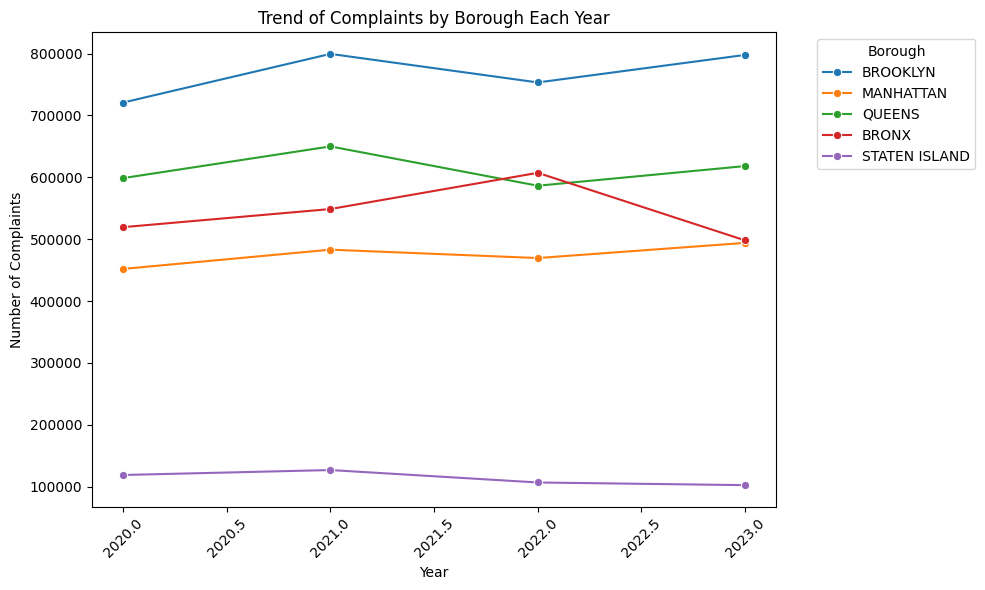

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 4: Plotting the trend of number of complaints by year for each borough
plt.figure(figsize=(10, 6))
sns.lineplot(data=complaints_by_year_borough_pd, x="year", y="count", hue="Borough", marker="o")

# Step 5: Customize the plot
plt.title("Trend of Complaints by Borough Each Year")
plt.xlabel("Year")
plt.ylabel("Number of Complaints")
plt.xticks(rotation=45)
plt.legend(title="Borough", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show the plot
plt.tight_layout()
plt.show()

In [31]:
df_with_year.groupBy("Borough", "Complaint Type").count().orderBy(F.desc("count")).show()

+---------+--------------------+------+
|  Borough|      Complaint Type| count|
+---------+--------------------+------+
|    BRONX| Noise - Residential|504727|
| BROOKLYN|     Illegal Parking|497109|
|   QUEENS|     Illegal Parking|424283|
| BROOKLYN| Noise - Residential|353800|
|   QUEENS| Noise - Residential|282934|
|MANHATTAN| Noise - Residential|260701|
|MANHATTAN|Noise - Street/Si...|239506|
|   QUEENS|    Blocked Driveway|238163|
| BROOKLYN|Request Large Bul...|235811|
|    BRONX|     Illegal Parking|227422|
| BROOKLYN|    Blocked Driveway|218024|
|   QUEENS|Request Large Bul...|214972|
|    BRONX|Noise - Street/Si...|204392|
|MANHATTAN|     Illegal Parking|192998|
| BROOKLYN|Noise - Street/Si...|151740|
|    BRONX|      HEAT/HOT WATER|138348|
| BROOKLYN|      HEAT/HOT WATER|113152|
|    BRONX|    Blocked Driveway|102246|
|    BRONX|UNSANITARY CONDITION| 94756|
|MANHATTAN|      HEAT/HOT WATER| 94232|
+---------+--------------------+------+
only showing top 20 rows



In [35]:
df_with_day = service_requests_after2020.withColumn(
    "day_of_week", F.date_format("Created Date", "E")
)

df_with_day.groupBy("day_of_week").count().orderBy("count", ascending=False).show()

+-----------+-------+
|day_of_week|  count|
+-----------+-------+
|        Mon|1465753|
|        Tue|1456601|
|        Sun|1451394|
|        Fri|1433428|
|        Wed|1421663|
|        Sat|1415572|
|        Thu|1407065|
+-----------+-------+



In [37]:
service_requests_after2020.groupBy("Borough","Incident Zip").count().orderBy(F.desc("count")).show()

+---------+------------+------+
|  Borough|Incident Zip| count|
+---------+------------+------+
|    BRONX|       10466|292606|
| BROOKLYN|       11226|157560|
|   QUEENS|       11385|154029|
|    BRONX|       10457|149133|
|    BRONX|       10468|142353|
|    BRONX|       10467|138143|
| BROOKLYN|       11207|132455|
|    BRONX|       10452|131775|
|    BRONX|       10453|127185|
| BROOKLYN|       11208|125036|
|    BRONX|       10456|124284|
|    BRONX|       10458|122376|
| BROOKLYN|       11221|121438|
|MANHATTAN|       10031|113459|
|MANHATTAN|       10032|107029|
|   QUEENS|       11368|101599|
| BROOKLYN|       11216| 96539|
| BROOKLYN|       11201| 94820|
|    BRONX|       10472| 92540|
|MANHATTAN|       10034| 91932|
+---------+------------+------+
only showing top 20 rows



In [40]:
df_with_year.groupBy("year").agg(
    F.avg("processing_days").alias("avg_processing_time")
).orderBy("year").show()

+----+-------------------+
|year|avg_processing_time|
+----+-------------------+
|2020| 11.236168643928332|
|2021|   9.50436519670955|
|2022|  9.342910703242556|
|2023|  4.686530186801328|
+----+-------------------+



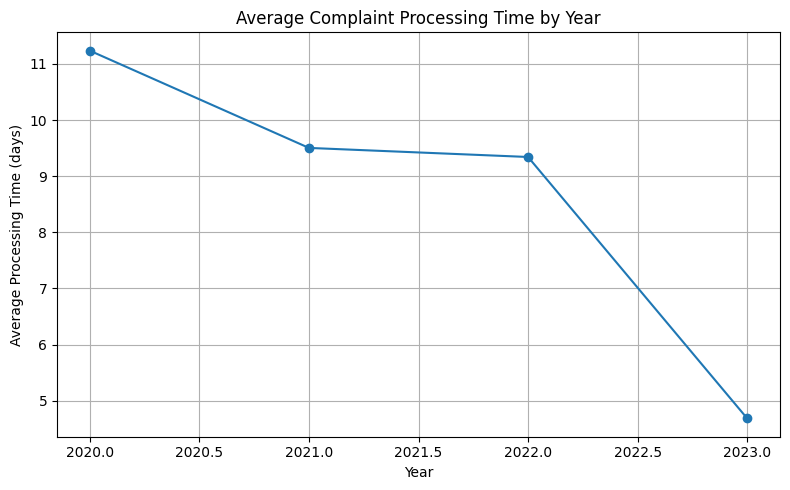

In [41]:
pandas_df = df_with_year.groupBy("year").agg(
    F.avg("processing_days").alias("avg_processing_time")
).orderBy("year").toPandas()

# Plot the results
pandas_df.plot(
    x="year", y="avg_processing_time", kind="line", marker='o', figsize=(8, 5),
    title="Average Complaint Processing Time by Year", legend=False, grid=True
)

plt.xlabel("Year")
plt.ylabel("Average Processing Time (days)")
plt.tight_layout()
plt.show()

In [42]:
df_with_year.groupBy("Borough").agg(
    F.avg("processing_days").alias("avg_processing_time")
).orderBy(F.desc("avg_processing_time")).show()

+-------------+-------------------+
|      Borough|avg_processing_time|
+-------------+-------------------+
|     BROOKLYN|   9.94938428544134|
|STATEN ISLAND|  9.450981645937887|
|    MANHATTAN|  9.055419961370625|
|       QUEENS|  8.533535517536848|
|        BRONX| 6.5421656472723795|
+-------------+-------------------+



In [44]:
df_with_hour = service_requests_after2020.withColumn("hour", F.hour("Created Date"))

df_with_hour.groupBy("hour").count().orderBy("count",ascending=False).show()

+----+------+
|hour| count|
+----+------+
|  22|588645|
|  10|562055|
|   9|561576|
|  12|561381|
|  11|559350|
|  21|538873|
|  23|535637|
|  14|528790|
|  13|522592|
|  15|506615|
|  16|498622|
|  20|482018|
|  17|470410|
|  19|461910|
|   8|461664|
|  18|461533|
|   0|438490|
|   7|297522|
|   1|289671|
|   2|190061|
+----+------+
only showing top 20 rows



In [45]:
spark.stop()